# [DLAI - Understanding and Applying Text embeddings](https://learn.deeplearning.ai/courses/google-cloud-vertex-ai)

## Project environment setup

- Load credentials and relevant Python Libraries
- If you were running this notebook locally, you would first install Vertex AI.  In this classroom, this is already installed.

In [ ]:
#!pip install 
#!pip install google-cloud-aiplatform

from utils import authenticate
credentials, PROJECT_ID = authenticate() # Get credentials and project ID

## Application of Embeddings


In [ ]:
from vertexai.language_models import TextGenerationModel

generation_model = TextGenerationModel.from_pretrained("text-bison@001") # for Q&A
generation_model = TextGenerationModel.from_pretrained("chat-bison@001") # for chatbots

# This is from public list of questions and answers from Stack overflow
# question_embeddings has embeddings of the questions only. The code to create this is not present in this file, therefore this section will not work
question_embeddings

### Cluster the embeddings of the Stack Overflow questions

In [ ]:
from sklearn.cluster import KMeans

clustering_dataset = question_embeddings[:1000]
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, 
                random_state=0, 
                n_init = 'auto').fit(clustering_dataset)
kmeans_labels = kmeans.labels_

# Reduce dimensionality to help visualize
from sklearn.decomposition import PCA
PCA_model = PCA(n_components=2)
PCA_model.fit(clustering_dataset)
new_values = PCA_model.transform(clustering_dataset)

# To visualize
import matplotlib.pyplot as plt
import mplcursors
%matplotlib ipympl
from utils import clusters_2D
clusters_2D(x_values = new_values[:,0], y_values = new_values[:,1], 
            labels = so_df[:1000], kmeans_labels = kmeans_labels)

### Use Isolation Forest to identify potential outliers

- `IsolationForest` classifier will predict `-1` for potential outliers, and `1` for non-outliers.
- You can inspect the rows that were predicted to be potential outliers and verify that the question about baking is predicted to be an outlier.

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.005, random_state = 2) 
preds = clf.fit_predict(question_embeddings)

print(f"{len(preds)} predictions. Set of possible values: {set(preds)}")
so_df.loc[preds == -1]

### Classification
- Train a random forest model to classify the category of a Stack Overflow question (as either Python, R, HTML or CSS).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# read the category from the file to get Y
so_df = pd.read_csv('so_database_app.csv')
y = so_df['category'].values
y.shape

# X would be question_embeddings
X = question_embeddings
X.shape

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 2)

clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) # compute accuracy
print("Accuracy:", accuracy)

# choose a number between 0 and 1999
i = 2
label = so_df.loc[i,'category']
question = so_df.loc[i,'input_text']

## LLMs for Question Answering
- You can ask an open-ended question to the language model.

In [ ]:
prompt = "I'm a high school student. Recommend me a programming activity to improve my skills."
generation_model.predict(prompt=prompt).text

### Adjusting Creativity/Randomness
- You can control the behavior of the language model's decoding strategy by adjusting the temperature, top-k, and top-n parameters.
- For tasks for which you want the model to consistently output the same result for the same input, (such as classification or information extraction), set temperature to zero.
- For tasks where you desire more creativity, such as brainstorming, summarization, choose a higher temperature (up to 1).

In [ ]:
temperature = 0.0
response = generation_model.predict(
    prompt=prompt,
    temperature=temperature,
)
generation_model.predict(prompt=prompt).text

#### Top P
- Top p: sample the minimum set of tokens whose probabilities add up to probability `p` or greater.
- The default value for `top_p` is `0.95`.
- If you want to adjust `top_p` and `top_k` and see different results, remember to set `temperature` to be greater than zero, otherwise the model will always choose the token with the highest probability.

In [ ]:
top_p = 0.2
prompt = "Write an advertisement for jackets \
that involves blue elephants and avocados."
response = generation_model.predict(
    prompt=prompt, 
    temperature=0.9, 
    top_p=top_p,
)
print(response.text)

#### Top k
- The default value for `top_k` is `40`.
- You can set `top_k` to values between `1` and `40`.
- The decoding strategy applies `top_k`, then `top_p`, then `temperature` (in that order).

top_k = 20
top_p = 0.7
response = generation_model.predict(
    prompt=prompt, 
    temperature=0.9, 
    top_k=top_k,
    top_p=top_p,
)
print(response.text)

## LLMs for Semantic Search, Building a Q&A System

Building a database within python (you can also use vector dbs)

In [ ]:
# Read external data, here it is in form of a CSV
import pandas as pd
so_database = pd.read_csv('so_database_app.csv')

# Import text embedding model to convert the external text to embeddings
from vertexai.language_models import TextEmbeddingModel
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

# Here is the code that embeds the text
import numpy as np
from utils import encode_text_to_embedding_batched

so_questions = so_database.input_text.tolist()
question_embeddings = encode_text_to_embedding_batched(
            sentences = so_questions,
            api_calls_per_second = 20/60, 
            batch_size = 5)

import pickle
with open('question_embeddings_app.pkl', 'rb') as file:
      
    # Call load method to deserialze
    question_embeddings = pickle.load(file)

# Add embeddings as a column to the dataframe
so_database['embeddings'] = question_embeddings.tolist()

### Semantic Search

When a user asks a question, we can embed their query on the fly and search over all of the Stack Overflow question embeddings to find the most simliar datapoint.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances_argmin as distances_argmin

query = ['How to concat dataframes pandas']
query_embedding = embedding_model.get_embeddings(query)[0].values

# Calculate the cosine similarity between query and every embedding (building an index)
# First arguemnt is a list of list, there query_embedding in within a parenthesis. second argument is a list, there array is converted to a list 
cos_sim_array = cosine_similarity([query_embedding], list(so_database.embeddings.values))

# This is (1,2000), so index is calculated for the query with every data point
cos_sim_array.shape

# Grab the question with the max cosine
index_doc_cosine = np.argmax(cos_sim_array)
index_doc_distances = distances_argmin([query_embedding], list(so_database.embeddings.values))[0]
so_database.input_text[index_doc_cosine]
so_database.output_text[index_doc_cosine]

### Question answering with relevant context

Now that we have found the most simliar Stack Overflow question, we can take the corresponding answer and use an LLM to produce a more conversational response.

In [ ]:
from vertexai.language_models import TextGenerationModel
generation_model = TextGenerationModel.from_pretrained(
    "text-bison@001")

context = "Question: " + so_database.input_text[index_doc_cosine] +\
"\n Answer: " + so_database.output_text[index_doc_cosine]

# if the question isn't actually relevant when answering the user query? 
# we added additional instructions in the prompt to handle those cases
prompt = f"""Here is the context: {context}
             Using the relevant information from the context,
             provide an answer to the query: {query}."
             If the context doesn't provide \
             any relevant information, \
             answer with \
             [I couldn't find a good match in the \
             document database for your query]
             """

from IPython.display import Markdown, display

t_value = 0.2
response = generation_model.predict(prompt = prompt, temperature = t_value, max_output_tokens = 1024)

display(Markdown(response.text))

### Scale with approximate nearest neighbor search

When dealing with a large dataset, computing the similarity between the query and each original embedded document in the database might be too expensive. Instead of doing that, you can use approximate nearest neighbor algorithms that find the most similar documents in a more efficient way.

These algorithms usually work by creating an index for your data, and using that index to find the most similar documents for your queries. In this notebook, we will use ScaNN to demonstrate the benefits of efficient vector similarity search. First, you have to create an index for your embedded dataset.

In [ ]:
import scann
from utils import create_index

#Create index using scann
index = create_index(embedded_dataset = question_embeddings, 
                     num_leaves = 25,
                     num_leaves_to_search = 10,
                     training_sample_size = 2000)

query = "how to concat dataframes pandas"

import time 

# Use scann
start = time.time()
query_embedding = embedding_model.get_embeddings([query])[0].values
neighbors, distances = index.search(query_embedding, final_num_neighbors = 1)
end = time.time()

for id, dist in zip(neighbors, distances):
    print(f"[docid:{id}] [{dist}] -- {so_database.input_text[int(id)][:125]}...")

print("Latency (ms):", 1000 * (end - start))

# Use cosine similarity
start = time.time()
query_embedding = embedding_model.get_embeddings([query])[0].values
cos_sim_array = cosine_similarity([query_embedding], list(so_database.embeddings.values))
index_doc = np.argmax(cos_sim_array)
end = time.time()

print(f"[docid:{index_doc}] [{np.max(cos_sim_array)}] -- {so_database.input_text[int(index_doc)][:125]}...")

print("Latency (ms):", 1000 * (end - start))

# [Course - DLAI: Vector DBs](https://learn.deeplearning.ai/courses/vector-databases-embeddings-applications) 
Generate Embeddings for images(from MNIST) and NLP sentences

## Using VAE model to generate embeddings
we train a VAE model on MNSIT database and then use it to generate and visual embeddings for MNIST images

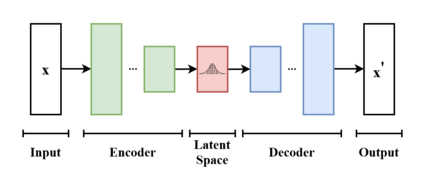

In [ ]:
!pip install matplotlib
!pip install tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist #MNIST is a dataset images which has hand written digits, labels (which is the actual value) are also part of the dataset
from scipy.stats import norm

In [ ]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

#Normalize arrays between 0 & 1
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.

# Reshape images (flatten) - convert 28,28 array into 28*28=768,1 array
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

# Example of a training image
plt.imshow(x_tr[1]);

In [ ]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses

# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

In [ ]:
# sampling function - to grab "batch_size" number of images for each training epoc
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [ ]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer of encoder
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer of encoder

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat) #latent space
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

### Visualize Embeddings

In [ ]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

### Example: compare three embeddings

In [ ]:
plt.imshow(x_te_flat[10].reshape(28,28));
plt.imshow(x_te_flat[13].reshape(28,28));
plt.imshow(x_te_flat[2].reshape(28,28));

# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

## Sentence embeddings

In [ ]:
#!pip install sentence_transformers
%pip install tf-keras
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

# Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

embedding.shape

In [ ]:
# %pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

In [ ]:
# Euclidean distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())

# alternative way of calculating using numpy library
np.linalg.norm((zero_A - zero_B), ord=2)

In [ ]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

In [ ]:
# Dot Product
np.dot(zero_A,zero_B)

In [ ]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))

# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

# [Course DLAI: Embedding Models: from Architecture to Implementation](https://learn.deeplearning.ai/courses/embedding-models-from-architecture-to-implementation)
Use BERT or GLoVE for generating vector embeddings

## GloVe word embeddings

In [3]:
# ! pip install gensim
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [5]:
# Words to visualize
import numpy as np
words = ["king", "princess", "monarch", "throne", "crown", 
         "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [8]:
# Reduce dimensions using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

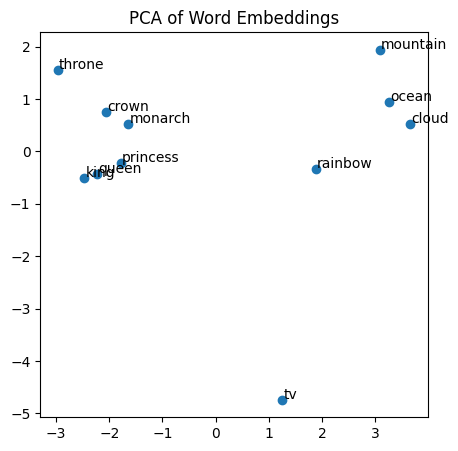

In [9]:
# Plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA of Word Embeddings')
plt.show()

## BERT Embeddings

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

In [13]:
sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."

word = "bat"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]

## Word2Vec algebra

In [14]:
result = word_vectors.most_similar(positive=['king', 'woman'], 
                                   negative=['man'], topn=1)

# Output the result
print(f"""
    The word closest to 'king' - 'man' + 'woman' is: '{result[0][0]}' 
    with a similarity score of {result[0][1]}""")


    The word closest to 'king' - 'man' + 'woman' is: 'queen' 
    with a similarity score of 0.7698540687561035


## GloVe vs BERT: words in context

In [15]:
print("BERT Embedding for 'bat' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'bat' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'bat':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")

BERT Embedding for 'bat' in sentence 1: [ 0.41316193 -0.12908176 -0.44865787 -0.40492722 -0.15305707]
BERT Embedding for 'bat' in sentence 2: [ 0.6406694  -0.3112153  -0.44089836 -0.16551146 -0.20056167]
GloVe Embedding for 'bat': [-0.47601  0.81705  0.11151 -0.22687 -0.80672]

Cosine Similarity between BERT embeddings in different contexts: 0.4599575102329254
Cosine Similarity between GloVe embeddings: 1.0


## Cross Encoder

In [16]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512, 
                     default_activation_function=torch.nn.Sigmoid())

In [ ]:
question = "Where is the capital of France?"
# Define sentences to compare
answers = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain."
]

In [ ]:
scores = model.predict([(question, answers[0]), (question, answers[1]),
                        (question, answers[2])])
print(scores)
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")